# Import packages


In [53]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings

In [54]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler


# Load data


In [55]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [56]:
# stock_name = "^GSPC"
# date_predict_start = '2021-01-01'
# data_range = 10
# slide_range = 5
# n_slide = 3
# pv_range = 2
# n_harm_lower_limit = 3
# n_harm_upper_limit = 3
# fit_method = 'rmse'
# pv_method = 'HL'
# date_data_start_list = []
# date_predict_start_list = []
# date_predict_end_list = []
# train_data = {}
# test_data = {}
# date_predict_start = datetime.datetime.strptime(date_predict_start, '%Y-%m-%d')
# all_data = yf.Ticker(stock_name).history(period='max')

# check = date_predict_start in list(all_data.index)
# while (check == False) :
#     date_predict_start = date_predict_start + \
#         relativedelta(days=+1)
#     check = date_predict_start in list(all_data.index)
# predict_start = all_data.index.get_loc(date_predict_start)
# for i in range(n_slide):
#     predict_end = predict_start + data_range
#     date_predict_end = all_data.iloc[predict_end].name
#     data_start = predict_start - data_range
#     date_data_start = all_data.iloc[data_start].name
#     train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
#     test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
#     date_data_start_list.append(date_data_start)
#     date_predict_start_list.append(date_predict_start)
#     date_predict_end_list.append(date_predict_end)
#     data_start = data_start + slide_range
#     predict_start = predict_start + slide_range


# Data preprocessing


In [57]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [58]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [59]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [60]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # mix harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [61]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            for j in range(n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [62]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [63]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [64]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [65]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [66]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [67]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [68]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [69]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [70]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [71]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [72]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [73]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [74]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valley'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valley'


In [75]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    for d in test_data :
        test_data[d].index = test_data[d]['index']
        test_data[d]= test_data[d].drop(test_data[d][test_data[d].index > date_list[-1]].index)
        axes[0].plot(test_data[d].index, test_data[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data :
        axes[0].plot(test_data[d].index, test_data[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data[d].index, test_data[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [76]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [77]:
# stock_name = "^GSPC"
# date_predict_start = '2020-01-01'
# data_range = 250
# slide_range = 10
# n_slide = 2
# pv_range = 2
# order_lower_limit = 0
# order_upper_limit = 50
# fit_method = 'rmse'
# pv_method = 'HL'
# # 1. load_data
# train_data, test_data, all_data, test_data_start_list = load_data(
#     stock_name, date_predict_start, data_range, slide_range, n_slide)
# # 2. Preprocessing
# preprocessing(train_data, test_data, pv_range, pv_method)


In [78]:
def SARIMAX_predict_function(train_data, p_range, d_range, q_range, P_range, D_range, Q_range, s): 
    model_pdq = {}
    model_fit = {}
    model_prediction = {}
    for i in train_data:
        train = train_data[i]['Close']
        index_length = len(p_range)*len(d_range)*len(q_range)*len(P_range)*len(D_range)*len(Q_range)
        model_pdq[i] = pd.DataFrame(columns=['p','d','q','P','D','Q','s'], index=range(0, index_length))
        model_fit[i] = {}
        model_prediction[i] = {}
        index = 0
        for p in p_range:
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in D_range:
                            for Q in Q_range:
                                try:
                                    # Fit the SARIMA model to the training data
                                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                    model_fit[i][index] = model.fit()
                                    model_prediction[i][index] = pd.DataFrame(columns=['Close'])
                                    model_prediction[i][index]['Close'] = model_fit[i][index].predict(start=train.index[0], end=train.index[-1]*2+1)
                                    model_pdq[i]['p'].iloc[index]=p
                                    model_pdq[i]['d'].iloc[index]=d
                                    model_pdq[i]['q'].iloc[index]=q
                                    model_pdq[i]['P'].iloc[index]=P
                                    model_pdq[i]['D'].iloc[index]=D
                                    model_pdq[i]['Q'].iloc[index]=Q
                                    model_pdq[i]['s'].iloc[index]=s
                                    index+=1
                                    print(i, index, '/', index_length)
                                except:
                                    pass

    return model_fit, model_prediction, model_pdq

In [79]:
def SARIMAX_select_model(model_fit, model_aic, data_range):
    best_predictions = {}
    min_value = int()
    for i in model_aic:
        min_key, min_value = min(
            zip(model_aic[i].keys(), model_aic[i].values()))
        best_predictions[i] = model_fit[i][0].predict(
            start=data_range, end=data_range*2-1)
    return best_predictions, min_value


In [80]:
# best_predictions, min_value = SARIMAX_select_model(model_fit, model_aic, data_range)

In [81]:
def draw_sarima_result(train_data, test_data, predictions):
    plt.figure(figsize=(20,6))
    plt.plot(train_data, label='train')
    plt.plot(predictions.index, test_data[:len(predictions)], label='test')
    plt.plot(predictions.index, predictions, label='predictions')
    # plt.xlim(len(train_data-10), len(train_data+10))
    plt.legend()
    plt.show()

In [82]:
def find_sarima_pv_function(sarima_predictions, pv_range):
    pd.options.mode.chained_assignment = None
    processed_signal = {}
    for i in sarima_predictions:
        processed_signal[i] = pd.DataFrame()
        price = sarima_predictions[i].reset_index(drop=True)
        processed_signal[i]['Close'] = sarima_predictions[i].reset_index(drop=True)
        processed_signal[i]['peaks'] = pd.Series(dtype='float64')
        processed_signal[i]['valleys'] = pd.Series(dtype='float64')
        processed_signal[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    processed_signal[i]['peaks'].iloc[idx] = price[idx]
                    processed_signal[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    processed_signal[i]['valleys'].iloc[idx] = price[idx]
                    processed_signal[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                processed_signal[i]['peaks'].iloc[idx] = price[idx]
                processed_signal[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                processed_signal[i]['valleys'].iloc[idx] = price[idx]
                processed_signal[i]['pv'].iloc[idx] = 'valley'
            # new rule for all zero
    return processed_signal


In [83]:
# processed_signal = find_sarima_pv_function(best_predictions, pv_range)

In [84]:
def find_sarima_lead_train_function(data, processed_signal):
    for d in data:
        # processed_signal[d]['pv'] = pd.Series(dtype='str')
        processing_signal = processed_signal[d].head(len(data[d]))
        # print(processing_signal)
        p_data = pd.DataFrame(
            {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[d]['lead'] = pd.Series(dtype='float64')
        processed_signal[d]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
        processed_signal[d]['lead'].loc[v_signal['lead'].index] = v_signal['lead']

In [85]:
# find_sarima_lead_train_function(train_data, processed_signal)

In [86]:
def build_model_sarima(train_data, pv_range, data_range):
    p_range = range(0, 3)
    d_range = range(0, 3)
    q_range = range(1, 2)
    P_range = range(0, 3)
    D_range = range(0, 3)
    Q_range = range(1, 2)
    s = 12
    model_fit, model_aic, model_pdq = SARIMAX_predict_function(train_data, p_range, d_range, q_range, P_range, D_range, Q_range, s) # type: ignore
    best_predictions, min_value = SARIMAX_select_model(model_fit, model_aic, data_range)
    processed_signal = find_sarima_pv_function(best_predictions, pv_range)
    find_sarima_lead_train_function(train_data, processed_signal)
    return processed_signal

In [87]:
# processed_signal = build_model_sarima(train_data, pv_range, data_range)

In [88]:
def get_fit_error_function_sarima(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        signal_dropna = processed_signal[i].drop(
            processed_signal[i][processed_signal[i]['lead'].isna()].index)
        if fit_method == 'mean':
            error = signal_dropna['lead'].mean()
        elif fit_method == 'abs':
            error = abs(signal_dropna['lead']).mean()
        elif fit_method == 'rmse':
            mse = np.square(np.subtract(np.zeros_like(
                signal_dropna['lead']), signal_dropna['lead'])).mean()
            rmse = math.sqrt(mse)
            error = rmse
        else :
            print('worng fit_method')
        errors[i] = error
    return errors


In [89]:
def find_sarima_lead_test_function(data, processed_signal):
    for d in data:
        # processed_signal[d]['pv'] = pd.Series(dtype='str')
        processing_signal = processed_signal[d].tail(len(data[d]))
        p_data = pd.DataFrame(
            {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[d]['lead'] = pd.Series(dtype='float64')
        processed_signal[d]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
        processed_signal[d]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [90]:
def get_first_lead_function_sarima(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        temp = processed_signal[i].loc[list(
            processed_signal[i]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [91]:
def select_model_sarima(test_data, processed_signal, fit_method):
    errors = get_fit_error_function_sarima(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_sarima_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function_sarima(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


In [92]:
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model_sarima(test_data, processed_signal, fit_method)

In [93]:
def result_table_process_function_sarima(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(
            datetime.datetime.strptime(result_table.loc[i].s_date, '%Y-%m-%d').date()) + first_date[i] - data_range].name
        t_date = datetime.datetime.strftime(t_date, '%Y-%m-%d')
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(
            datetime.datetime.strptime(result_table.loc[i].s_date, '%Y-%m-%d').date()) + result_table.loc[i, 'lead'])].name
        ans = datetime.datetime.strftime(ans, '%Y-%m-%d')
        result_table.loc[i, 'ans_date'] = ans


In [94]:
def evaluate_model_sarima(best_predictions, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        best_predictions, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function_sarima(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error

In [95]:
def built_result_table_function_sarima(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [96]:
# result_table = built_result_table_function_sarima(
#         processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)

In [97]:
# result_table_process_function_sarima(
#         result_table, all_data, first_date, data_range)

In [98]:
# final_error = compute_final_error_function(result_table)

In [99]:
# result_table, final_error = evaluate_model_sarima(
#     processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
# print('final_error = ', final_error)
# with pd.option_context('display.max_rows', None,
#                     'display.max_columns', None,
#                     'display.precision', 3,
#                     ):
#     print(result_table)

In [123]:
def draw_sarima_result(test_data, model_prediction, best_fit_harm):
    for i in test_data:
        fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
        print(i)
        pdq = best_fit_harm[i]
        prediction = model_prediction[i][pdq].loc[len(test_data[i]['Close']): len(test_data[i]['Close'])*2]
        prediction.index = test_data[i]['Close'].index
        axes[0].plot(test_data[i]['Close'].index, test_data[i]['Close'], label='test')
        axes[1].plot(prediction['Close'].index, prediction['Close'], label='predictions')
        for j, label in enumerate(prediction['pv']):
            if test_data[i]['pv'][j] == 'peak':
                axes[0].plot(test_data[i]['Close'].index[j], test_data[i]['Close'][j], '^',
                            c='royalblue')
            elif test_data[i]['pv'][j] == 'valley':
                axes[0].plot(test_data[i]['Close'].index[j], test_data[i]['Close'][j], 'v',
                            c='orangered')
            if prediction['pv'][j] == 'peak':
                axes[1].plot(prediction['Close'].index[j], prediction['Close'][j], '^',
                            c='royalblue')
            elif prediction['pv'][j] == 'valley':
                axes[1].plot(prediction['Close'].index[j], prediction['Close'][j], 'v',
                            c='orangered')
        plt.legend()
        plt.show()

In [101]:
# def draw_plot_result_table_sarima(test_data, all_data, result_table, pv_range):
#     date_list = sorted(
#         list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
#     all_index = all_data.loc[datetime.datetime.strptime(date_list[0], '%Y-%m-%d').date():datetime.datetime.strptime(date_list[-1], '%Y-%m-%d').date()].index
#     fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
#     for d in test_data :
#         test_data[d].index = test_data[d]['index']
#         test_data[d]= test_data[d].drop(test_data[d][test_data[d].index > datetime.datetime.strptime(date_list[-1], '%Y-%m-%d').date()].index)
#         axes[0].plot(test_data[d].index, test_data[d]['Close'], 'gray', label='data', linewidth=3)
#     for d in test_data :
#         axes[0].plot(test_data[d].index, test_data[d]['peaks'],
#                     '^', c='royalblue', label='peaks')
#         axes[0].plot(test_data[d].index, test_data[d]['valleys'], 'v',
#                     c='orangered', label='valleys')
#     plot_model = pd.DataFrame(index=all_index, columns=[
#                                 's_date', 't_date', 'ans_date', 'lead', 'pv'])
#     print(plot_model)
#     # plot_model['s_date'].loc[result_table['s_date']] = True
#     # plot_model['t_date'].loc[result_table['t_date']] = True
#     # plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
#     # plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
#     # plot_model['ans_date'].loc[result_table['ans_date']] = True
#     # for i, label in enumerate(plot_model['lead']):
#     #     if plot_model['pv'][i] == 'peak':
#     #         # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#     #         #             c='red')
#     #         axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
#     #                         c='royalblue')
#     #         text = str(label)
#     #         axes[1].annotate(text, (plot_model.index[i],
#     #                             plot_model['lead'][i]), fontsize=14)
#     #     elif plot_model['pv'][i] == 'valley':
#     #         # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#     #         #             c='red')
#     #         axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
#     #                         c='orangered')
#     #         text = str(label)
#     #         axes[1].annotate(text, (plot_model.index[i],
#     #                             plot_model['lead'][i]), fontsize=14)

#     # axes[0].set_ylabel("Stock price", fontsize=14)
#     # axes[0].grid(True)
#     # axes[1].grid(True)
#     # axes[1].set_ylabel("lead", fontsize=14)
#     # plt.show()

In [102]:
def main_funtion_sarima(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, fit_method, pv_method):
    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    model = build_model_sarima(train_data, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model_sarima(test_data, model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model_sarima(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        'display.precision', 3,
                        ):
        print(result_table)
    return model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [103]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 5
pv_range = 2
fit_method = 'rmse'
pv_method = 'CL'

In [104]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)

In [105]:
def normorlize_train_test_sarima(train_data, data_range):
    # Assuming your time series data is stored in a NumPy array called 'ts_data'
    normalized_train = train_data
    for i in train_data:
        array_data = np.array(train_data[i]['Close'])
        n_data = array_data.size
        time_data = np.arange(0, n_data)
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data  # detrended x
        scaler = MinMaxScaler(feature_range=(-1, 1))
        normalized_data = scaler.fit_transform(data_notrend.reshape(-1, 1)).reshape(-1)
        normalized_train[i]['Close'] = pd.Series(normalized_data, name='Close', index=train_data[i]['Close'].index)
    return normalized_train

In [106]:
train_data = normorlize_train_test_sarima(train_data, data_range)
test_data = normorlize_train_test_sarima(test_data, data_range)


In [107]:
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)

In [108]:
# 3. Build model
p_range = range(0, 3)
d_range = range(0, 3)
q_range = range(0, 2)
P_range = range(0, 3)
D_range = range(0, 3)
Q_range = range(0, 2)
s = 12
model_fit, model_prediction, model_pdq = SARIMAX_predict_function(
    train_data, p_range, d_range, q_range, P_range, D_range, Q_range, s) # type: ignore


data_0 1 / 324
data_0 2 / 324
data_0 3 / 324
data_0 4 / 324
data_0 5 / 324
data_0 6 / 324
data_0 7 / 324
data_0 8 / 324
data_0 9 / 324
data_0 10 / 324
data_0 11 / 324
data_0 12 / 324
data_0 13 / 324
data_0 14 / 324
data_0 15 / 324
data_0 16 / 324
data_0 17 / 324
data_0 18 / 324
data_0 19 / 324
data_0 20 / 324
data_0 21 / 324
data_0 22 / 324
data_0 23 / 324
data_0 24 / 324
data_0 25 / 324
data_0 26 / 324
data_0 27 / 324
data_0 28 / 324
data_0 29 / 324
data_0 30 / 324
data_0 31 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 32 / 324
data_0 33 / 324
data_0 34 / 324
data_0 35 / 324
data_0 36 / 324
data_0 37 / 324
data_0 38 / 324
data_0 39 / 324
data_0 40 / 324
data_0 41 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 42 / 324
data_0 43 / 324
data_0 44 / 324
data_0 45 / 324
data_0 46 / 324
data_0 47 / 324
data_0 48 / 324
data_0 49 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 50 / 324
data_0 51 / 324
data_0 52 / 324
data_0 53 / 324
data_0 54 / 324
data_0 55 / 324
data_0 56 / 324
data_0 57 / 324
data_0 58 / 324
data_0 59 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 60 / 324
data_0 61 / 324
data_0 62 / 324
data_0 63 / 324
data_0 64 / 324
data_0 65 / 324
data_0 66 / 324
data_0 67 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 68 / 324
data_0 69 / 324
data_0 70 / 324
data_0 71 / 324
data_0 72 / 324
data_0 73 / 324
data_0 74 / 324
data_0 75 / 324
data_0 76 / 324
data_0 77 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 78 / 324
data_0 79 / 324
data_0 80 / 324
data_0 81 / 324
data_0 82 / 324
data_0 83 / 324
data_0 84 / 324
data_0 85 / 324
data_0 86 / 324
data_0 87 / 324
data_0 88 / 324
data_0 89 / 324
data_0 90 / 324
data_0 91 / 324
data_0 92 / 324
data_0 93 / 324
data_0 94 / 324
data_0 95 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 96 / 324
data_0 97 / 324
data_0 98 / 324
data_0 99 / 324
data_0 100 / 324
data_0 101 / 324
data_0 102 / 324
data_0 103 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 104 / 324
data_0 105 / 324
data_0 106 / 324
data_0 107 / 324
data_0 108 / 324
data_0 109 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 110 / 324
data_0 111 / 324
data_0 112 / 324
data_0 113 / 324
data_0 114 / 324
data_0 115 / 324
data_0 116 / 324
data_0 117 / 324
data_0 118 / 324
data_0 119 / 324
data_0 120 / 324
data_0 121 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 122 / 324
data_0 123 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 124 / 324
data_0 125 / 324
data_0 126 / 324
data_0 127 / 324
data_0 128 / 324
data_0 129 / 324
data_0 130 / 324
data_0 131 / 324
data_0 132 / 324
data_0 133 / 324
data_0 134 / 324
data_0 135 / 324
data_0 136 / 324
data_0 137 / 324
data_0 138 / 324
data_0 139 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 140 / 324
data_0 141 / 324
data_0 142 / 324
data_0 143 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 144 / 324
data_0 145 / 324
data_0 146 / 324
data_0 147 / 324
data_0 148 / 324
data_0 149 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 150 / 324
data_0 151 / 324
data_0 152 / 324
data_0 153 / 324
data_0 154 / 324
data_0 155 / 324
data_0 156 / 324
data_0 157 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 158 / 324
data_0 159 / 324
data_0 160 / 324
data_0 161 / 324
data_0 162 / 324
data_0 163 / 324
data_0 164 / 324
data_0 165 / 324
data_0 166 / 324
data_0 167 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 168 / 324
data_0 169 / 324
data_0 170 / 324
data_0 171 / 324
data_0 172 / 324
data_0 173 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 174 / 324
data_0 175 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 176 / 324
data_0 177 / 324
data_0 178 / 324
data_0 179 / 324
data_0 180 / 324
data_0 181 / 324
data_0 182 / 324
data_0 183 / 324
data_0 184 / 324
data_0 185 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 186 / 324
data_0 187 / 324
data_0 188 / 324
data_0 189 / 324
data_0 190 / 324
data_0 191 / 324
data_0 192 / 324
data_0 193 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 194 / 324
data_0 195 / 324
data_0 196 / 324
data_0 197 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 198 / 324
data_0 199 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 200 / 324
data_0 201 / 324
data_0 202 / 324
data_0 203 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 204 / 324
data_0 205 / 324
data_0 206 / 324
data_0 207 / 324
data_0 208 / 324
data_0 209 / 324
data_0 210 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 211 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 212 / 324
data_0 213 / 324
data_0 214 / 324
data_0 215 / 324
data_0 216 / 324
data_0 217 / 324
data_0 218 / 324
data_0 219 / 324
data_0 220 / 324
data_0 221 / 324
data_0 222 / 324
data_0 223 / 324
data_0 224 / 324
data_0 225 / 324
data_0 226 / 324
data_0 227 / 324
data_0 228 / 324
data_0 229 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 230 / 324
data_0 231 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 232 / 324
data_0 233 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 234 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_0 235 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_0 236 / 324
data_0 237 / 324
data_0 238 / 324
data_0 239 / 324
data_0 240 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_0 241 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 242 / 324
data_0 243 / 324
data_0 244 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 245 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 246 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_0 247 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 248 / 324
data_0 249 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 250 / 324
data_0 251 / 324
data_0 252 / 324
data_0 253 / 324
data_0 254 / 324
data_0 255 / 324
data_0 256 / 324
data_0 257 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 258 / 324
data_0 259 / 324
data_0 260 / 324
data_0 261 / 324
data_0 262 / 324
data_0 263 / 324
data_0 264 / 324
data_0 265 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 266 / 324
data_0 267 / 324
data_0 268 / 324
data_0 269 / 324
data_0 270 / 324
data_0 271 / 324
data_0 272 / 324
data_0 273 / 324
data_0 274 / 324
data_0 275 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 276 / 324
data_0 277 / 324
data_0 278 / 324
data_0 279 / 324
data_0 280 / 324
data_0 281 / 324
data_0 282 / 324
data_0 283 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 284 / 324
data_0 285 / 324
data_0 286 / 324
data_0 287 / 324
data_0 288 / 324
data_0 289 / 324
data_0 290 / 324
data_0 291 / 324
data_0 292 / 324
data_0 293 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 294 / 324
data_0 295 / 324
data_0 296 / 324
data_0 297 / 324
data_0 298 / 324
data_0 299 / 324
data_0 300 / 324
data_0 301 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 302 / 324
data_0 303 / 324
data_0 304 / 324
data_0 305 / 324
data_0 306 / 324
data_0 307 / 324
data_0 308 / 324
data_0 309 / 324
data_0 310 / 324
data_0 311 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 312 / 324
data_0 313 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 314 / 324
data_0 315 / 324
data_0 316 / 324
data_0 317 / 324
data_0 318 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 319 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 320 / 324
data_0 321 / 324
data_0 322 / 324
data_0 323 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 324 / 324
data_1 1 / 324
data_1 2 / 324
data_1 3 / 324
data_1 4 / 324
data_1 5 / 324
data_1 6 / 324
data_1 7 / 324
data_1 8 / 324
data_1 9 / 324
data_1 10 / 324
data_1 11 / 324
data_1 12 / 324
data_1 13 / 324
data_1 14 / 324
data_1 15 / 324
data_1 16 / 324
data_1 17 / 324
data_1 18 / 324
data_1 19 / 324
data_1 20 / 324
data_1 21 / 324
data_1 22 / 324
data_1 23 / 324
data_1 24 / 324
data_1 25 / 324
data_1 26 / 324
data_1 27 / 324
data_1 28 / 324
data_1 29 / 324
data_1 30 / 324
data_1 31 / 324
data_1 32 / 324
data_1 33 / 324
data_1 34 / 324
data_1 35 / 324
data_1 36 / 324
data_1 37 / 324
data_1 38 / 324
data_1 39 / 324
data_1 40 / 324
data_1 41 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_1 42 / 324
data_1 43 / 324
data_1 44 / 324
data_1 45 / 324
data_1 46 / 324
data_1 47 / 324
data_1 48 / 324
data_1 49 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 50 / 324
data_1 51 / 324
data_1 52 / 324
data_1 53 / 324
data_1 54 / 324
data_1 55 / 324
data_1 56 / 324
data_1 57 / 324
data_1 58 / 324
data_1 59 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_1 60 / 324
data_1 61 / 324
data_1 62 / 324
data_1 63 / 324
data_1 64 / 324
data_1 65 / 324
data_1 66 / 324
data_1 67 / 324
data_1 68 / 324
data_1 69 / 324
data_1 70 / 324
data_1 71 / 324
data_1 72 / 324
data_1 73 / 324
data_1 74 / 324
data_1 75 / 324
data_1 76 / 324
data_1 77 / 324
data_1 78 / 324
data_1 79 / 324
data_1 80 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 81 / 324
data_1 82 / 324
data_1 83 / 324
data_1 84 / 324
data_1 85 / 324
data_1 86 / 324
data_1 87 / 324
data_1 88 / 324
data_1 89 / 324
data_1 90 / 324
data_1 91 / 324
data_1 92 / 324
data_1 93 / 324
data_1 94 / 324
data_1 95 / 324
data_1 96 / 324
data_1 97 / 324
data_1 98 / 324
data_1 99 / 324
data_1 100 / 324
data_1 101 / 324
data_1 102 / 324
data_1 103 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 104 / 324
data_1 105 / 324
data_1 106 / 324
data_1 107 / 324
data_1 108 / 324
data_1 109 / 324
data_1 110 / 324
data_1 111 / 324
data_1 112 / 324
data_1 113 / 324
data_1 114 / 324
data_1 115 / 324
data_1 116 / 324
data_1 117 / 324
data_1 118 / 324
data_1 119 / 324
data_1 120 / 324
data_1 121 / 324
data_1 122 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 123 / 324
data_1 124 / 324
data_1 125 / 324
data_1 126 / 324
data_1 127 / 324
data_1 128 / 324
data_1 129 / 324
data_1 130 / 324
data_1 131 / 324
data_1 132 / 324
data_1 133 / 324
data_1 134 / 324
data_1 135 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 136 / 324
data_1 137 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 138 / 324
data_1 139 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 140 / 324
data_1 141 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 142 / 324
data_1 143 / 324
data_1 144 / 324
data_1 145 / 324
data_1 146 / 324
data_1 147 / 324
data_1 148 / 324
data_1 149 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_1 150 / 324
data_1 151 / 324
data_1 152 / 324
data_1 153 / 324
data_1 154 / 324
data_1 155 / 324
data_1 156 / 324
data_1 157 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 158 / 324
data_1 159 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 160 / 324
data_1 161 / 324
data_1 162 / 324
data_1 163 / 324
data_1 164 / 324
data_1 165 / 324
data_1 166 / 324
data_1 167 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_1 168 / 324
data_1 169 / 324
data_1 170 / 324
data_1 171 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 172 / 324
data_1 173 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 174 / 324
data_1 175 / 324
data_1 176 / 324
data_1 177 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 178 / 324
data_1 179 / 324
data_1 180 / 324
data_1 181 / 324
data_1 182 / 324
data_1 183 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 184 / 324
data_1 185 / 324
data_1 186 / 324
data_1 187 / 324
data_1 188 / 324
data_1 189 / 324
data_1 190 / 324
data_1 191 / 324
data_1 192 / 324
data_1 193 / 324
data_1 194 / 324
data_1 195 / 324
data_1 196 / 324
data_1 197 / 324
data_1 198 / 324
data_1 199 / 324
data_1 200 / 324
data_1 201 / 324
data_1 202 / 324
data_1 203 / 324
data_1 204 / 324
data_1 205 / 324
data_1 206 / 324
data_1 207 / 324
data_1 208 / 324
data_1 209 / 324
data_1 210 / 324
data_1 211 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 212 / 324
data_1 213 / 324
data_1 214 / 324
data_1 215 / 324
data_1 216 / 324
data_1 217 / 324
data_1 218 / 324
data_1 219 / 324
data_1 220 / 324
data_1 221 / 324
data_1 222 / 324
data_1 223 / 324
data_1 224 / 324
data_1 225 / 324
data_1 226 / 324
data_1 227 / 324
data_1 228 / 324
data_1 229 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 230 / 324
data_1 231 / 324
data_1 232 / 324
data_1 233 / 324
data_1 234 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_1 235 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 236 / 324
data_1 237 / 324
data_1 238 / 324
data_1 239 / 324
data_1 240 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_1 241 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 242 / 324
data_1 243 / 324
data_1 244 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 245 / 324
data_1 246 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_1 247 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 248 / 324
data_1 249 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 250 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 251 / 324
data_1 252 / 324
data_1 253 / 324
data_1 254 / 324
data_1 255 / 324
data_1 256 / 324
data_1 257 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_1 258 / 324
data_1 259 / 324
data_1 260 / 324
data_1 261 / 324
data_1 262 / 324
data_1 263 / 324
data_1 264 / 324
data_1 265 / 324
data_1 266 / 324
data_1 267 / 324
data_1 268 / 324
data_1 269 / 324
data_1 270 / 324
data_1 271 / 324
data_1 272 / 324
data_1 273 / 324
data_1 274 / 324
data_1 275 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 276 / 324
data_1 277 / 324
data_1 278 / 324
data_1 279 / 324
data_1 280 / 324
data_1 281 / 324
data_1 282 / 324
data_1 283 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 284 / 324
data_1 285 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 286 / 324
data_1 287 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 288 / 324
data_1 289 / 324
data_1 290 / 324
data_1 291 / 324
data_1 292 / 324
data_1 293 / 324
data_1 294 / 324
data_1 295 / 324
data_1 296 / 324
data_1 297 / 324
data_1 298 / 324
data_1 299 / 324
data_1 300 / 324
data_1 301 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 302 / 324
data_1 303 / 324
data_1 304 / 324
data_1 305 / 324
data_1 306 / 324
data_1 307 / 324
data_1 308 / 324
data_1 309 / 324
data_1 310 / 324
data_1 311 / 324
data_1 312 / 324
data_1 313 / 324
data_1 314 / 324
data_1 315 / 324
data_1 316 / 324
data_1 317 / 324
data_1 318 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 319 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 320 / 324
data_1 321 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 322 / 324
data_1 323 / 324
data_1 324 / 324
data_2 1 / 324
data_2 2 / 324
data_2 3 / 324
data_2 4 / 324
data_2 5 / 324
data_2 6 / 324
data_2 7 / 324
data_2 8 / 324
data_2 9 / 324
data_2 10 / 324
data_2 11 / 324
data_2 12 / 324
data_2 13 / 324
data_2 14 / 324
data_2 15 / 324
data_2 16 / 324
data_2 17 / 324
data_2 18 / 324
data_2 19 / 324
data_2 20 / 324
data_2 21 / 324
data_2 22 / 324
data_2 23 / 324
data_2 24 / 324
data_2 25 / 324
data_2 26 / 324
data_2 27 / 324
data_2 28 / 324
data_2 29 / 324
data_2 30 / 324
data_2 31 / 324
data_2 32 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 33 / 324
data_2 34 / 324
data_2 35 / 324
data_2 36 / 324
data_2 37 / 324
data_2 38 / 324
data_2 39 / 324
data_2 40 / 324
data_2 41 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 42 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 43 / 324
data_2 44 / 324
data_2 45 / 324
data_2 46 / 324
data_2 47 / 324
data_2 48 / 324
data_2 49 / 324
data_2 50 / 324
data_2 51 / 324
data_2 52 / 324
data_2 53 / 324
data_2 54 / 324
data_2 55 / 324
data_2 56 / 324
data_2 57 / 324
data_2 58 / 324
data_2 59 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 60 / 324
data_2 61 / 324
data_2 62 / 324
data_2 63 / 324
data_2 64 / 324
data_2 65 / 324
data_2 66 / 324
data_2 67 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 68 / 324
data_2 69 / 324
data_2 70 / 324
data_2 71 / 324
data_2 72 / 324
data_2 73 / 324
data_2 74 / 324
data_2 75 / 324
data_2 76 / 324
data_2 77 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 78 / 324
data_2 79 / 324
data_2 80 / 324
data_2 81 / 324
data_2 82 / 324
data_2 83 / 324
data_2 84 / 324
data_2 85 / 324
data_2 86 / 324
data_2 87 / 324
data_2 88 / 324
data_2 89 / 324
data_2 90 / 324
data_2 91 / 324
data_2 92 / 324
data_2 93 / 324
data_2 94 / 324
data_2 95 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 96 / 324
data_2 97 / 324
data_2 98 / 324
data_2 99 / 324
data_2 100 / 324
data_2 101 / 324
data_2 102 / 324
data_2 103 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 104 / 324
data_2 105 / 324
data_2 106 / 324
data_2 107 / 324
data_2 108 / 324
data_2 109 / 324
data_2 110 / 324
data_2 111 / 324
data_2 112 / 324
data_2 113 / 324
data_2 114 / 324
data_2 115 / 324
data_2 116 / 324
data_2 117 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 118 / 324
data_2 119 / 324
data_2 120 / 324
data_2 121 / 324
data_2 122 / 324
data_2 123 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 124 / 324
data_2 125 / 324
data_2 126 / 324
data_2 127 / 324
data_2 128 / 324
data_2 129 / 324
data_2 130 / 324
data_2 131 / 324
data_2 132 / 324
data_2 133 / 324
data_2 134 / 324
data_2 135 / 324
data_2 136 / 324
data_2 137 / 324
data_2 138 / 324
data_2 139 / 324
data_2 140 / 324
data_2 141 / 324
data_2 142 / 324
data_2 143 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 144 / 324
data_2 145 / 324
data_2 146 / 324
data_2 147 / 324
data_2 148 / 324
data_2 149 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 150 / 324
data_2 151 / 324
data_2 152 / 324
data_2 153 / 324
data_2 154 / 324
data_2 155 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 156 / 324
data_2 157 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 158 / 324
data_2 159 / 324
data_2 160 / 324
data_2 161 / 324
data_2 162 / 324
data_2 163 / 324
data_2 164 / 324
data_2 165 / 324
data_2 166 / 324
data_2 167 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 168 / 324
data_2 169 / 324
data_2 170 / 324
data_2 171 / 324
data_2 172 / 324
data_2 173 / 324
data_2 174 / 324
data_2 175 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 176 / 324
data_2 177 / 324
data_2 178 / 324
data_2 179 / 324
data_2 180 / 324
data_2 181 / 324
data_2 182 / 324
data_2 183 / 324
data_2 184 / 324
data_2 185 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 186 / 324
data_2 187 / 324
data_2 188 / 324
data_2 189 / 324
data_2 190 / 324
data_2 191 / 324
data_2 192 / 324
data_2 193 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 194 / 324
data_2 195 / 324
data_2 196 / 324
data_2 197 / 324
data_2 198 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 199 / 324
data_2 200 / 324
data_2 201 / 324
data_2 202 / 324
data_2 203 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 204 / 324
data_2 205 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 206 / 324
data_2 207 / 324
data_2 208 / 324
data_2 209 / 324
data_2 210 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 211 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 212 / 324
data_2 213 / 324
data_2 214 / 324
data_2 215 / 324
data_2 216 / 324
data_2 217 / 324
data_2 218 / 324
data_2 219 / 324
data_2 220 / 324
data_2 221 / 324
data_2 222 / 324
data_2 223 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 224 / 324
data_2 225 / 324
data_2 226 / 324
data_2 227 / 324
data_2 228 / 324
data_2 229 / 324
data_2 230 / 324
data_2 231 / 324
data_2 232 / 324
data_2 233 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 234 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_2 235 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 236 / 324
data_2 237 / 324
data_2 238 / 324
data_2 239 / 324
data_2 240 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_2 241 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 242 / 324
data_2 243 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 244 / 324
data_2 245 / 324
data_2 246 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_2 247 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 248 / 324
data_2 249 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 250 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 251 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 252 / 324
data_2 253 / 324
data_2 254 / 324
data_2 255 / 324
data_2 256 / 324
data_2 257 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 258 / 324
data_2 259 / 324
data_2 260 / 324
data_2 261 / 324
data_2 262 / 324
data_2 263 / 324
data_2 264 / 324
data_2 265 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 266 / 324
data_2 267 / 324
data_2 268 / 324
data_2 269 / 324
data_2 270 / 324
data_2 271 / 324
data_2 272 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 273 / 324
data_2 274 / 324
data_2 275 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 276 / 324
data_2 277 / 324
data_2 278 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 279 / 324
data_2 280 / 324
data_2 281 / 324
data_2 282 / 324
data_2 283 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 284 / 324
data_2 285 / 324
data_2 286 / 324
data_2 287 / 324
data_2 288 / 324
data_2 289 / 324
data_2 290 / 324
data_2 291 / 324
data_2 292 / 324
data_2 293 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 294 / 324
data_2 295 / 324
data_2 296 / 324
data_2 297 / 324
data_2 298 / 324
data_2 299 / 324
data_2 300 / 324
data_2 301 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 302 / 324
data_2 303 / 324
data_2 304 / 324
data_2 305 / 324
data_2 306 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 307 / 324
data_2 308 / 324
data_2 309 / 324
data_2 310 / 324
data_2 311 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 312 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 313 / 324
data_2 314 / 324
data_2 315 / 324
data_2 316 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 317 / 324
data_2 318 / 324
data_2 319 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 320 / 324
data_2 321 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 322 / 324
data_2 323 / 324
data_2 324 / 324
data_3 1 / 324
data_3 2 / 324
data_3 3 / 324
data_3 4 / 324
data_3 5 / 324
data_3 6 / 324
data_3 7 / 324
data_3 8 / 324
data_3 9 / 324
data_3 10 / 324
data_3 11 / 324
data_3 12 / 324
data_3 13 / 324
data_3 14 / 324
data_3 15 / 324
data_3 16 / 324
data_3 17 / 324
data_3 18 / 324
data_3 19 / 324
data_3 20 / 324
data_3 21 / 324
data_3 22 / 324
data_3 23 / 324
data_3 24 / 324
data_3 25 / 324
data_3 26 / 324
data_3 27 / 324
data_3 28 / 324
data_3 29 / 324
data_3 30 / 324
data_3 31 / 324
data_3 32 / 324
data_3 33 / 324
data_3 34 / 324
data_3 35 / 324
data_3 36 / 324
data_3 37 / 324
data_3 38 / 324
data_3 39 / 324
data_3 40 / 324
data_3 41 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 42 / 324
data_3 43 / 324
data_3 44 / 324
data_3 45 / 324
data_3 46 / 324
data_3 47 / 324
data_3 48 / 324
data_3 49 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 50 / 324
data_3 51 / 324
data_3 52 / 324
data_3 53 / 324
data_3 54 / 324
data_3 55 / 324
data_3 56 / 324
data_3 57 / 324
data_3 58 / 324
data_3 59 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 60 / 324
data_3 61 / 324
data_3 62 / 324
data_3 63 / 324
data_3 64 / 324
data_3 65 / 324
data_3 66 / 324
data_3 67 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 68 / 324
data_3 69 / 324
data_3 70 / 324
data_3 71 / 324
data_3 72 / 324
data_3 73 / 324
data_3 74 / 324
data_3 75 / 324
data_3 76 / 324
data_3 77 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 78 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 79 / 324
data_3 80 / 324
data_3 81 / 324
data_3 82 / 324
data_3 83 / 324
data_3 84 / 324
data_3 85 / 324
data_3 86 / 324
data_3 87 / 324
data_3 88 / 324
data_3 89 / 324
data_3 90 / 324
data_3 91 / 324
data_3 92 / 324
data_3 93 / 324
data_3 94 / 324
data_3 95 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 96 / 324
data_3 97 / 324
data_3 98 / 324
data_3 99 / 324
data_3 100 / 324
data_3 101 / 324
data_3 102 / 324
data_3 103 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 104 / 324
data_3 105 / 324
data_3 106 / 324
data_3 107 / 324
data_3 108 / 324
data_3 109 / 324
data_3 110 / 324
data_3 111 / 324
data_3 112 / 324
data_3 113 / 324
data_3 114 / 324
data_3 115 / 324
data_3 116 / 324
data_3 117 / 324
data_3 118 / 324
data_3 119 / 324
data_3 120 / 324
data_3 121 / 324
data_3 122 / 324
data_3 123 / 324
data_3 124 / 324
data_3 125 / 324
data_3 126 / 324
data_3 127 / 324
data_3 128 / 324
data_3 129 / 324
data_3 130 / 324
data_3 131 / 324
data_3 132 / 324
data_3 133 / 324
data_3 134 / 324
data_3 135 / 324
data_3 136 / 324
data_3 137 / 324
data_3 138 / 324
data_3 139 / 324
data_3 140 / 324
data_3 141 / 324
data_3 142 / 324
data_3 143 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 144 / 324
data_3 145 / 324
data_3 146 / 324
data_3 147 / 324
data_3 148 / 324
data_3 149 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 150 / 324
data_3 151 / 324
data_3 152 / 324
data_3 153 / 324
data_3 154 / 324
data_3 155 / 324
data_3 156 / 324
data_3 157 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 158 / 324
data_3 159 / 324
data_3 160 / 324
data_3 161 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 162 / 324
data_3 163 / 324
data_3 164 / 324
data_3 165 / 324
data_3 166 / 324
data_3 167 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 168 / 324
data_3 169 / 324
data_3 170 / 324
data_3 171 / 324
data_3 172 / 324
data_3 173 / 324
data_3 174 / 324
data_3 175 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 176 / 324
data_3 177 / 324
data_3 178 / 324
data_3 179 / 324
data_3 180 / 324
data_3 181 / 324
data_3 182 / 324
data_3 183 / 324
data_3 184 / 324
data_3 185 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 186 / 324
data_3 187 / 324
data_3 188 / 324
data_3 189 / 324
data_3 190 / 324
data_3 191 / 324
data_3 192 / 324
data_3 193 / 324
data_3 194 / 324
data_3 195 / 324
data_3 196 / 324
data_3 197 / 324
data_3 198 / 324
data_3 199 / 324
data_3 200 / 324
data_3 201 / 324
data_3 202 / 324
data_3 203 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 204 / 324
data_3 205 / 324
data_3 206 / 324
data_3 207 / 324
data_3 208 / 324
data_3 209 / 324
data_3 210 / 324
data_3 211 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 212 / 324
data_3 213 / 324
data_3 214 / 324
data_3 215 / 324
data_3 216 / 324
data_3 217 / 324
data_3 218 / 324
data_3 219 / 324
data_3 220 / 324
data_3 221 / 324
data_3 222 / 324
data_3 223 / 324
data_3 224 / 324
data_3 225 / 324
data_3 226 / 324
data_3 227 / 324
data_3 228 / 324
data_3 229 / 324
data_3 230 / 324
data_3 231 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 232 / 324
data_3 233 / 324
data_3 234 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_3 235 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 236 / 324
data_3 237 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 238 / 324
data_3 239 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 240 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_3 241 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 242 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 243 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 244 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 245 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 246 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_3 247 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 248 / 324
data_3 249 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 250 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 251 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 252 / 324
data_3 253 / 324
data_3 254 / 324
data_3 255 / 324
data_3 256 / 324
data_3 257 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 258 / 324
data_3 259 / 324
data_3 260 / 324
data_3 261 / 324
data_3 262 / 324
data_3 263 / 324
data_3 264 / 324
data_3 265 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 266 / 324
data_3 267 / 324
data_3 268 / 324
data_3 269 / 324
data_3 270 / 324
data_3 271 / 324
data_3 272 / 324
data_3 273 / 324
data_3 274 / 324
data_3 275 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 276 / 324
data_3 277 / 324
data_3 278 / 324
data_3 279 / 324
data_3 280 / 324
data_3 281 / 324
data_3 282 / 324
data_3 283 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 284 / 324
data_3 285 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 286 / 324
data_3 287 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 288 / 324
data_3 289 / 324
data_3 290 / 324
data_3 291 / 324
data_3 292 / 324
data_3 293 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 294 / 324
data_3 295 / 324
data_3 296 / 324
data_3 297 / 324
data_3 298 / 324
data_3 299 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 300 / 324
data_3 301 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 302 / 324
data_3 303 / 324
data_3 304 / 324
data_3 305 / 324
data_3 306 / 324
data_3 307 / 324
data_3 308 / 324
data_3 309 / 324
data_3 310 / 324
data_3 311 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 312 / 324
data_3 313 / 324
data_3 314 / 324
data_3 315 / 324
data_3 316 / 324
data_3 317 / 324
data_3 318 / 324
data_3 319 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 320 / 324
data_3 321 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 322 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 323 / 324
data_3 324 / 324
data_4 1 / 324
data_4 2 / 324
data_4 3 / 324
data_4 4 / 324
data_4 5 / 324
data_4 6 / 324
data_4 7 / 324
data_4 8 / 324
data_4 9 / 324
data_4 10 / 324
data_4 11 / 324
data_4 12 / 324
data_4 13 / 324
data_4 14 / 324
data_4 15 / 324
data_4 16 / 324
data_4 17 / 324
data_4 18 / 324
data_4 19 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 20 / 324
data_4 21 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 22 / 324
data_4 23 / 324
data_4 24 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 25 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 26 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 27 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 28 / 324
data_4 29 / 324
data_4 30 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 31 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 32 / 324
data_4 33 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 34 / 324
data_4 35 / 324
data_4 36 / 324
data_4 37 / 324
data_4 38 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 39 / 324
data_4 40 / 324
data_4 41 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 42 / 324
data_4 43 / 324
data_4 44 / 324
data_4 45 / 324
data_4 46 / 324
data_4 47 / 324
data_4 48 / 324
data_4 49 / 324
data_4 50 / 324
data_4 51 / 324
data_4 52 / 324
data_4 53 / 324
data_4 54 / 324
data_4 55 / 324
data_4 56 / 324
data_4 57 / 324
data_4 58 / 324
data_4 59 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 60 / 324
data_4 61 / 324
data_4 62 / 324
data_4 63 / 324
data_4 64 / 324
data_4 65 / 324
data_4 66 / 324
data_4 67 / 324
data_4 68 / 324
data_4 69 / 324
data_4 70 / 324
data_4 71 / 324
data_4 72 / 324
data_4 73 / 324
data_4 74 / 324
data_4 75 / 324
data_4 76 / 324
data_4 77 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 78 / 324
data_4 79 / 324
data_4 80 / 324
data_4 81 / 324
data_4 82 / 324
data_4 83 / 324
data_4 84 / 324
data_4 85 / 324
data_4 86 / 324
data_4 87 / 324
data_4 88 / 324
data_4 89 / 324
data_4 90 / 324
data_4 91 / 324
data_4 92 / 324
data_4 93 / 324
data_4 94 / 324
data_4 95 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 96 / 324
data_4 97 / 324
data_4 98 / 324
data_4 99 / 324
data_4 100 / 324
data_4 101 / 324
data_4 102 / 324
data_4 103 / 324
data_4 104 / 324
data_4 105 / 324
data_4 106 / 324
data_4 107 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 108 / 324
data_4 109 / 324
data_4 110 / 324
data_4 111 / 324
data_4 112 / 324
data_4 113 / 324
data_4 114 / 324
data_4 115 / 324
data_4 116 / 324
data_4 117 / 324
data_4 118 / 324
data_4 119 / 324
data_4 120 / 324
data_4 121 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 122 / 324
data_4 123 / 324
data_4 124 / 324
data_4 125 / 324
data_4 126 / 324
data_4 127 / 324
data_4 128 / 324
data_4 129 / 324
data_4 130 / 324
data_4 131 / 324
data_4 132 / 324
data_4 133 / 324
data_4 134 / 324
data_4 135 / 324
data_4 136 / 324
data_4 137 / 324
data_4 138 / 324
data_4 139 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 140 / 324
data_4 141 / 324
data_4 142 / 324
data_4 143 / 324
data_4 144 / 324
data_4 145 / 324
data_4 146 / 324
data_4 147 / 324
data_4 148 / 324
data_4 149 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 150 / 324
data_4 151 / 324
data_4 152 / 324
data_4 153 / 324
data_4 154 / 324
data_4 155 / 324
data_4 156 / 324
data_4 157 / 324
data_4 158 / 324
data_4 159 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 160 / 324
data_4 161 / 324
data_4 162 / 324
data_4 163 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters fo

data_4 164 / 324
data_4 165 / 324
data_4 166 / 324
data_4 167 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 168 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 169 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 170 / 324
data_4 171 / 324
data_4 172 / 324
data_4 173 / 324
data_4 174 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 175 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 176 / 324
data_4 177 / 324
data_4 178 / 324
data_4 179 / 324
data_4 180 / 324
data_4 181 / 324
data_4 182 / 324
data_4 183 / 324
data_4 184 / 324
data_4 185 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 186 / 324
data_4 187 / 324
data_4 188 / 324
data_4 189 / 324
data_4 190 / 324
data_4 191 / 324
data_4 192 / 324
data_4 193 / 324
data_4 194 / 324
data_4 195 / 324
data_4 196 / 324
data_4 197 / 324
data_4 198 / 324
data_4 199 / 324
data_4 200 / 324
data_4 201 / 324
data_4 202 / 324
data_4 203 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 204 / 324
data_4 205 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 206 / 324
data_4 207 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 208 / 324
data_4 209 / 324
data_4 210 / 324
data_4 211 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 212 / 324
data_4 213 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 214 / 324
data_4 215 / 324
data_4 216 / 324
data_4 217 / 324
data_4 218 / 324
data_4 219 / 324
data_4 220 / 324
data_4 221 / 324
data_4 222 / 324
data_4 223 / 324
data_4 224 / 324
data_4 225 / 324
data_4 226 / 324
data_4 227 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 228 / 324
data_4 229 / 324
data_4 230 / 324
data_4 231 / 324
data_4 232 / 324
data_4 233 / 324
data_4 234 / 324
data_4 235 / 324
data_4 236 / 324
data_4 237 / 324
data_4 238 / 324
data_4 239 / 324
data_4 240 / 324
data_4 241 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 242 / 324
data_4 243 / 324
data_4 244 / 324
data_4 245 / 324
data_4 246 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 247 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 248 / 324
data_4 249 / 324
data_4 250 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 251 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 252 / 324
data_4 253 / 324
data_4 254 / 324
data_4 255 / 324
data_4 256 / 324
data_4 257 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 258 / 324
data_4 259 / 324
data_4 260 / 324
data_4 261 / 324
data_4 262 / 324
data_4 263 / 324
data_4 264 / 324
data_4 265 / 324
data_4 266 / 324
data_4 267 / 324
data_4 268 / 324
data_4 269 / 324
data_4 270 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 271 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 272 / 324
data_4 273 / 324
data_4 274 / 324
data_4 275 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 276 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 277 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 278 / 324
data_4 279 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 280 / 324
data_4 281 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 282 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 283 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 284 / 324
data_4 285 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 286 / 324
data_4 287 / 324
data_4 288 / 324
data_4 289 / 324
data_4 290 / 324
data_4 291 / 324
data_4 292 / 324
data_4 293 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 294 / 324
data_4 295 / 324
data_4 296 / 324
data_4 297 / 324
data_4 298 / 324
data_4 299 / 324
data_4 300 / 324
data_4 301 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 302 / 324
data_4 303 / 324
data_4 304 / 324
data_4 305 / 324
data_4 306 / 324
data_4 307 / 324
data_4 308 / 324
data_4 309 / 324
data_4 310 / 324
data_4 311 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 312 / 324
data_4 313 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 314 / 324
data_4 315 / 324
data_4 316 / 324
data_4 317 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 318 / 324
data_4 319 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 320 / 324
data_4 321 / 324
data_4 322 / 324
data_4 323 / 324


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 324 / 324


In [109]:
find_signal_pv_function(model_prediction, pv_range)
find_signal_lead_train_function(train_data, model_prediction)

In [110]:
errors = get_fit_error_function(model_prediction, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    model_prediction, errors)
find_signal_lead_test_function(test_data, model_prediction)
first_date, lead, pv = get_first_lead_function(
    model_prediction, best_fit_harm)

In [111]:
for i in best_fit_harm:
    pdq = best_fit_harm[i]
    print(i)
    print(model_pdq[i].loc[pdq])

data_0
p     0
d     1
q     0
P     0
D     0
Q     0
s    12
Name: 36, dtype: object
data_1
p     0
d     1
q     0
P     0
D     0
Q     0
s    12
Name: 36, dtype: object
data_2
p     0
d     2
q     1
P     0
D     0
Q     0
s    12
Name: 90, dtype: object
data_3
p     0
d     1
q     0
P     0
D     0
Q     0
s    12
Name: 36, dtype: object
data_4
p     1
d     0
q     1
P     0
D     0
Q     0
s    12
Name: 126, dtype: object


In [112]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    model_prediction, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)


final_error =  3.8
            s_date      t_date lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-03 -1.0  2020-01-02    peak  1.08       36
data_1  2020-01-16  2020-01-17  0.0  2020-01-17    peak  0.99       36
data_2  2020-01-31  2021-01-27 -5.0  2021-01-20    peak  0.99       90
data_3  2020-02-14  2020-02-18  8.0  2020-02-28  valley  1.03       36
data_4  2020-03-02  2020-03-02  5.0  2020-03-09  valley  1.02      126


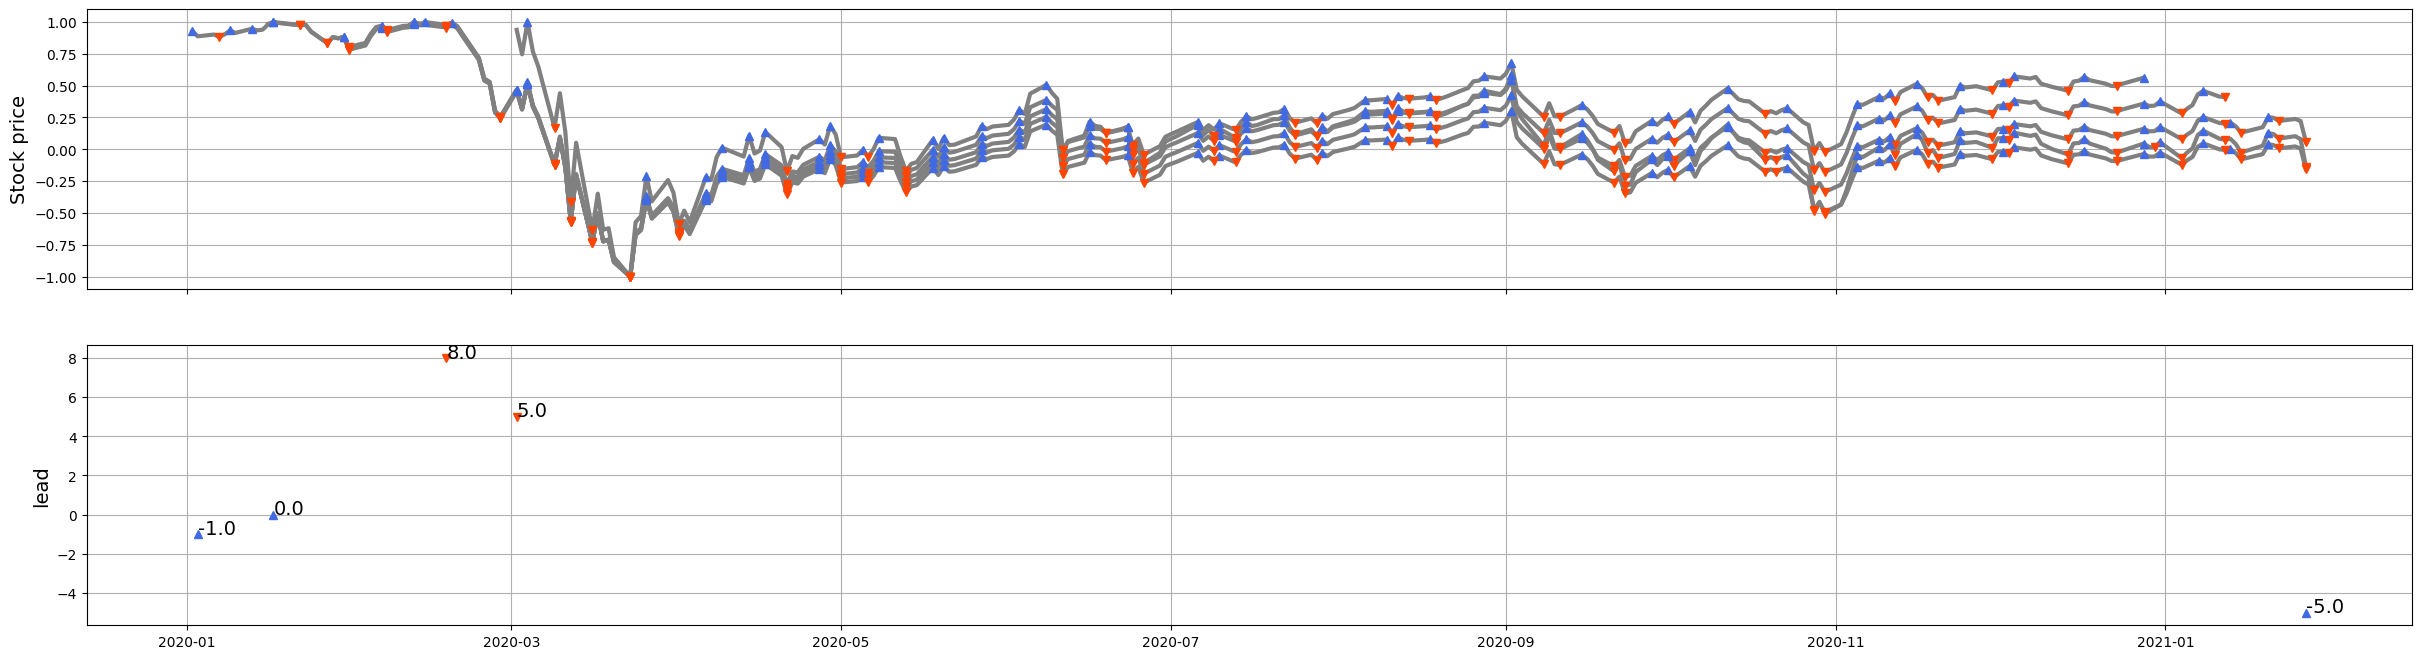

In [113]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

data_0


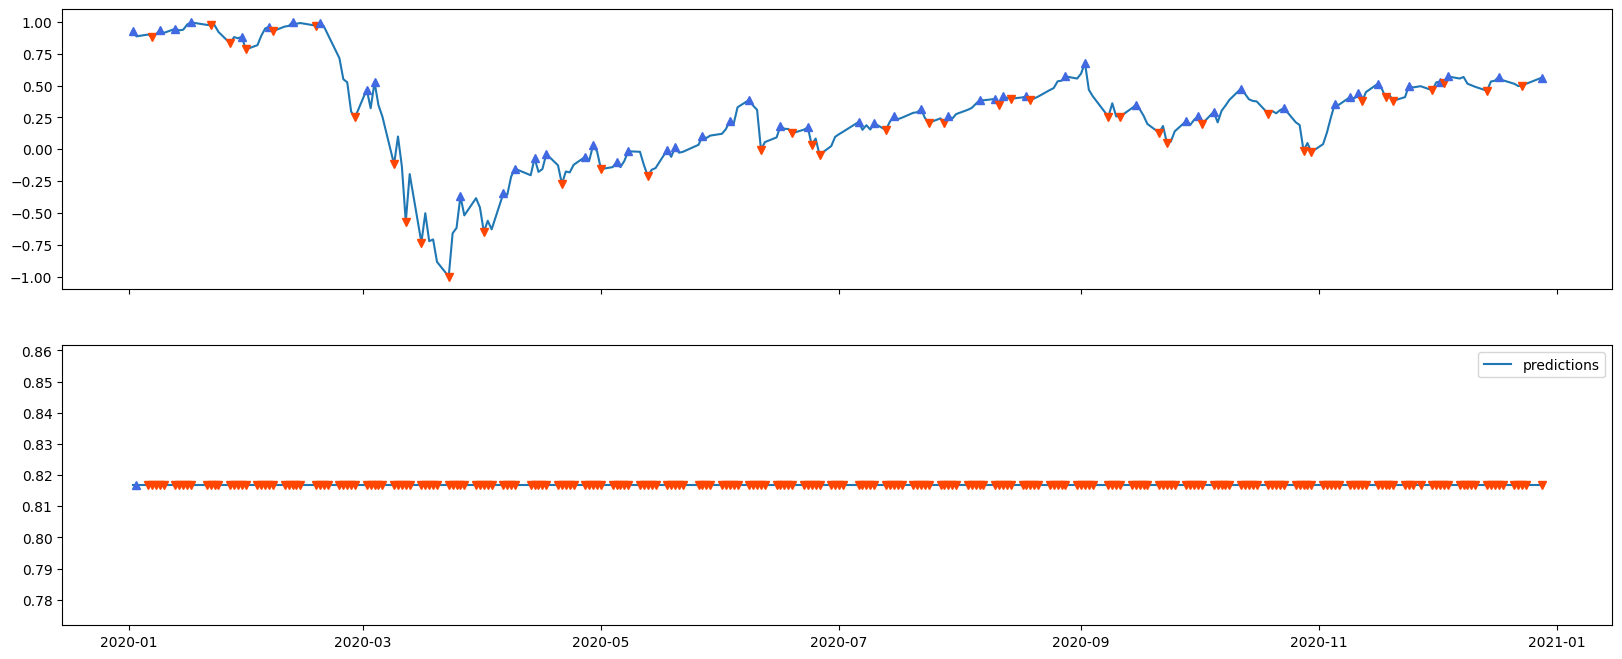

data_1


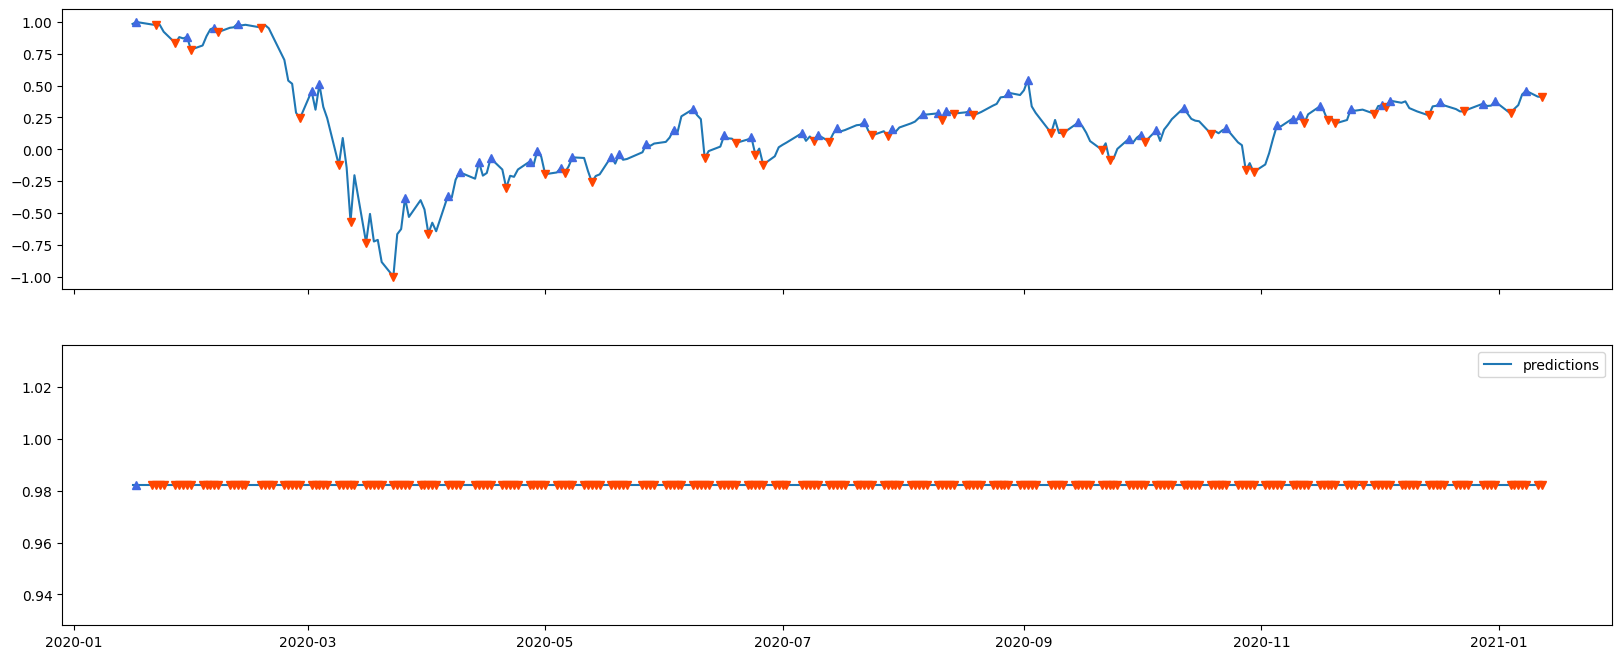

data_2


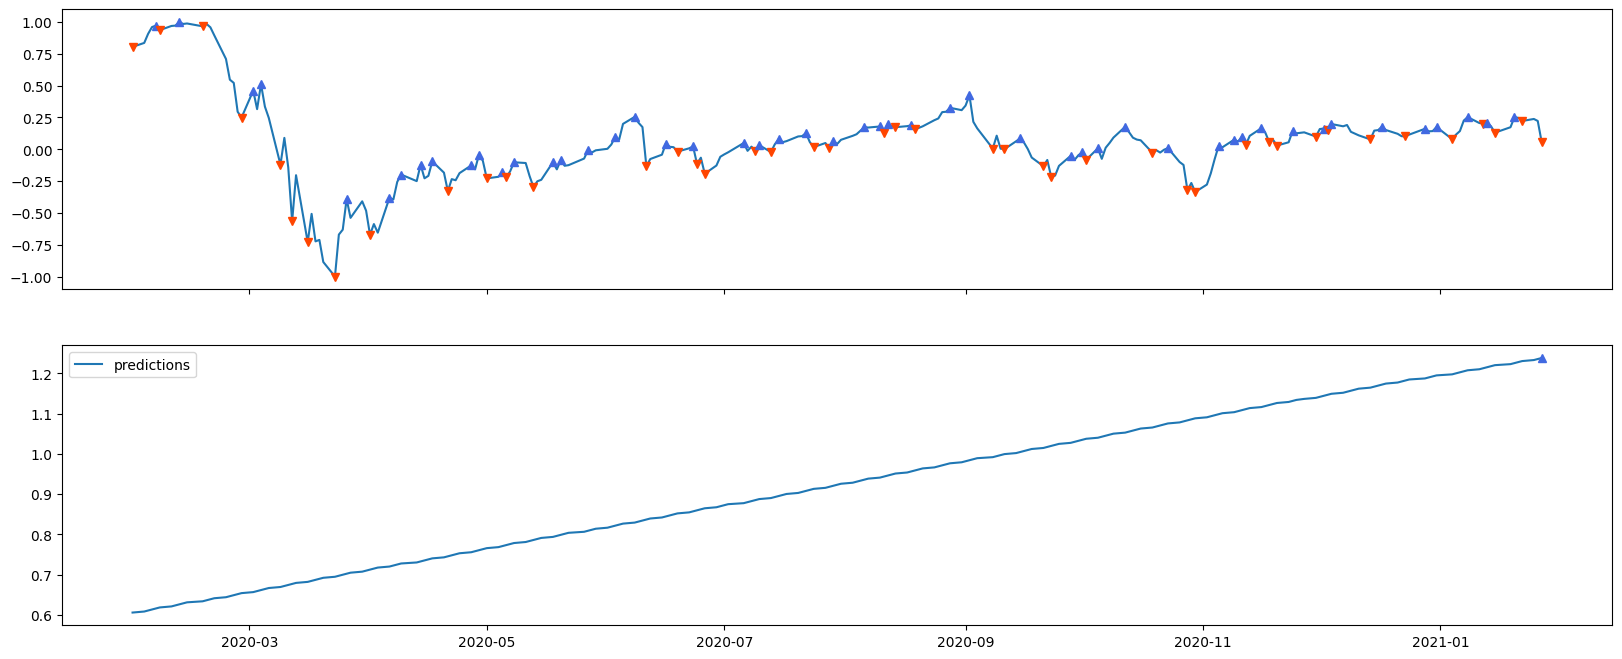

data_3


ValueError: Length mismatch: Expected axis has 241 elements, new values have 240 elements

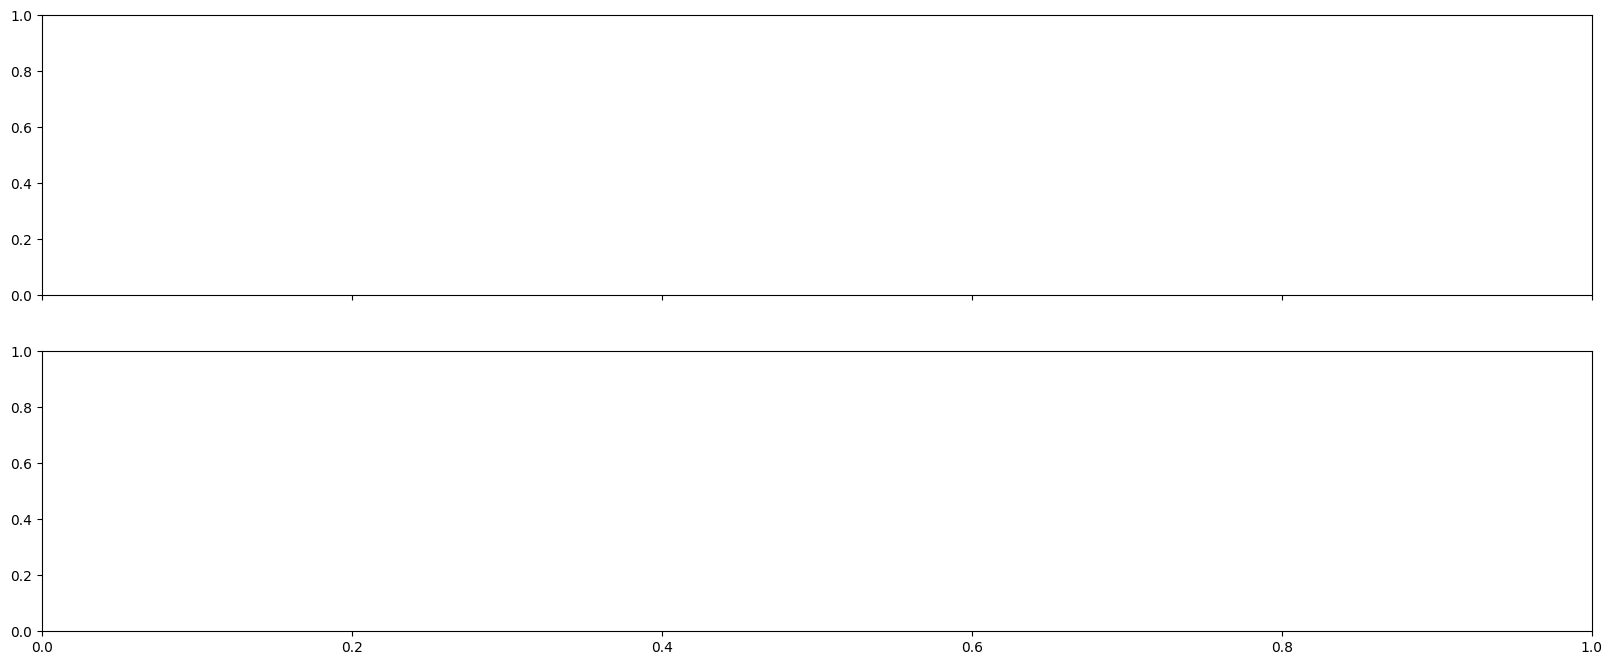

In [124]:
draw_sarima_result(test_data, model_prediction, best_fit_harm)